In [3]:
########################################################### IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary, set_trainable
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('../src')
from data_preparation import get_birth_data, separate_data_with_monday_flag

tf.keras.backend.set_floatx("float64")


In [7]:
tf.keras.backend.set_floatx("float64")

data = get_birth_data()
x, y, m = separate_data_with_monday_flag(data, normalised=True)
# x_w, y_w = separate_data(data, normalised=True, weekdays=True)

x = x.numpy()
y = y.numpy()
m = m.numpy()

def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs

pos, labels = get_xticks(data)

# plotting function
def plot_distribution(X, Y, loc, scale, pos, labels, CI=None):
    plt.figure(figsize=(25, 7))
    x = X.squeeze()

    if CI:
        lb = (loc - 1.96 * scale).squeeze()
        ub = (loc + 1.96 * scale).squeeze()

        plt.fill_between(x, lb, ub, color="C0", alpha=0.4)
    #plt.plot(x, lb, color="C0")
    #plt.plot(x, ub, color="C0")
    plt.plot(X, Y, '.', color="black", alpha=0.5, markersize=3)
    plt.plot(X, loc, color="C0")

    plt.title('EXP(GP)  --- Amazing!!!')
    plt.xticks(pos, labels)
    plt.xlabel('Date')
    plt.ylabel('Births')
    
    plt.show()
    plt.close()

In [8]:
from typing import Any, Optional, Type

import tensorflow as tf
import tensorflow_probability as tfp

from gpflow.utilities import positive
from gpflow.base import TensorType
from gpflow.likelihoods.multilatent import MultiLatentTFPConditional

class CustomTFPConditional(MultiLatentTFPConditional):
    """
    Heteroskedastic Likelihood where the conditional distribution
    is given by a TensorFlow Probability Distribution.
    The `loc` and `scale` of the distribution are given by a
    two-dimensional multi-output GP.
    """

    def __init__(
        self,
        distribution_class: Type[tfp.distributions.Distribution] = tfp.distributions.Normal,
        loc_transform: Optional[tfp.bijectors.Bijector] = None,
        monday_flag = None,
        **kwargs: Any,
    ) -> None:
        """
        :param distribution_class: distribution class parameterized by `loc` and `scale`
            as first and second argument, respectively.
        :param scale_transform: callable/bijector applied to the latent
            function modelling the scale to ensure its positivity.
            Typically, `tf.exp` or `tf.softplus`, but can be any function f: R -> R^+. Defaults to exp if not explicitly specified.
        """

        if loc_transform is None:
            loc_transform = tfp.bijectors.Identity()
        self.loc_transform = loc_transform
        self.monday_flag = monday_flag

        def conditional_distribution(Fs: TensorType) -> tfp.distributions.Distribution:
            tf.debugging.assert_equal(tf.shape(Fs)[-1], 2)
        
            scale_transform = positive(base="exp")
            scale = scale_transform(Fs[..., 1:])

            dist = tfd.Normal(loc=0., scale=1.)
            rsample = dist.sample([self.monday_flag.shape[0]])   
            rsample = tf.reshape(tf.cast(rsample, dtype=tf.float64), (rsample.shape[0],1))
            beta = tf.where(self.monday_flag == 1, rsample, 0)
            # (400, 7305, 2) = Fs.shape
            
            loc = Fs[..., :1] + beta * self.loc_transform(Fs[..., :1])
            return distribution_class(loc, scale)

        super().__init__(
            latent_dim=2,
            conditional_distribution=conditional_distribution,
            **kwargs,
        )

In [ ]:
likelihood = CustomTFPConditional(
    distribution_class = tfp.distributions.Normal, 
    loc_transform = tfp.bijectors.Exp(), 
    monday_flag = m,
)

#### jitter
kernel = gpflow.kernels.SeparateIndependent(
    [
        gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25),
        gpflow.kernels.RBF(),  
    ]
)


M = 3000  
Z = np.linspace(x.min(), x.max(), M)[:, None]  # [M, 1]

inducing_variable = gpflow.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpflow.inducing_variables.InducingPoints(Z),  
        gpflow.inducing_variables.InducingPoints(Z),  
    ]
)

model = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim,
    #whiten=False
)

##############################################################################################

data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)
set_trainable(model.kernel.kernels[0].kernels[1].period, False)
#gpflow.utilities.set_trainable(model.likelihood.variance, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 100
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = model.predict_y(x)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(x, y, Ymean, Ystd, pos, labels)

model

# Train/Test Split

2022-07-21 18:14:03.235337: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'base_conditional_args_to_map' can't be nonlocal (__autograph_generated_filepjmo09d8.py, line 23)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'base_conditional_args_to_map' can't be nonlocal (__autograph_generated_filepjmo09d8.py, line 23)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Use fn_output_signature instead


2022-07-21 18:14:12.472619: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x1cff9e30


Epoch 20 - Loss:  14598.8419


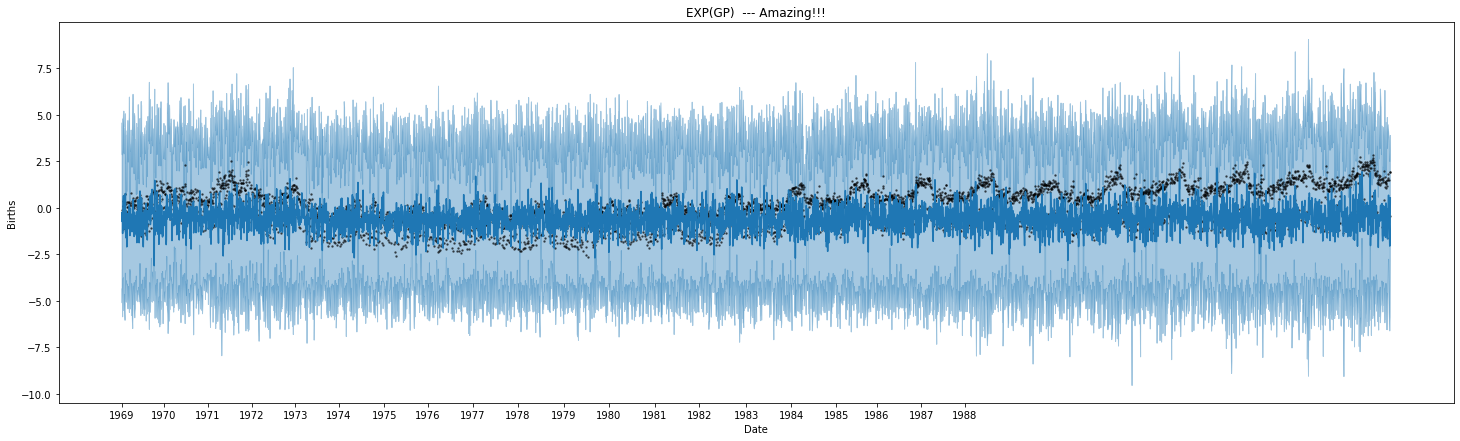

Epoch 40 - Loss:  12032.3041


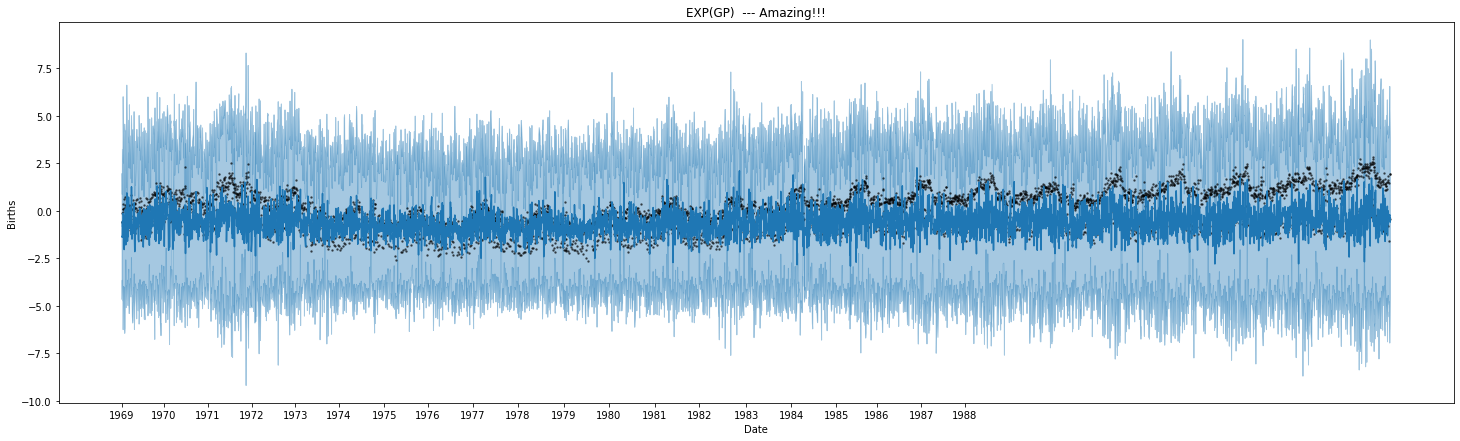

Epoch 60 - Loss:  11238.3265


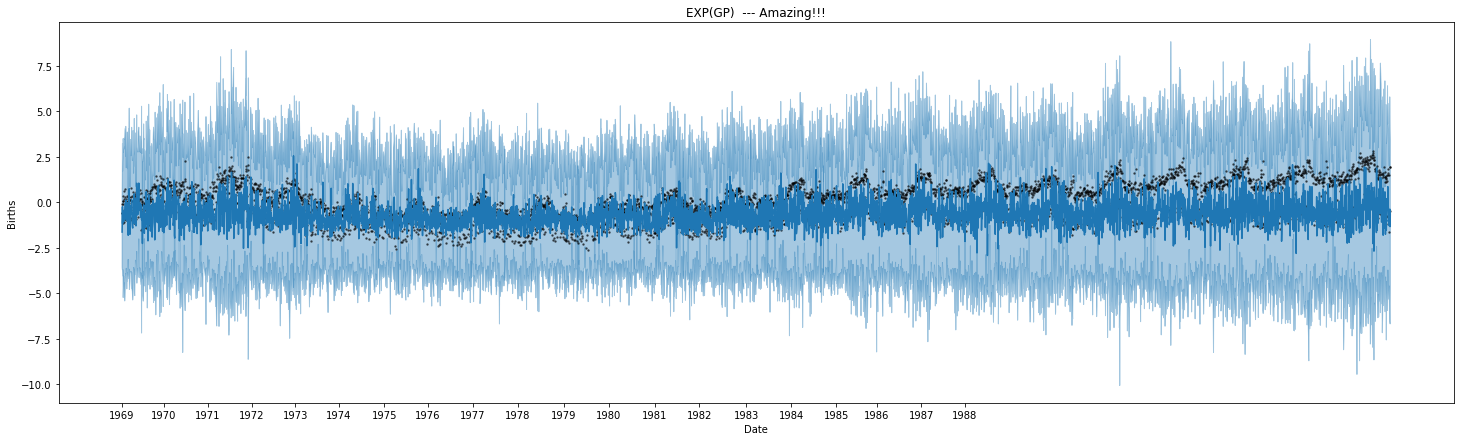

Epoch 80 - Loss:  10748.1881


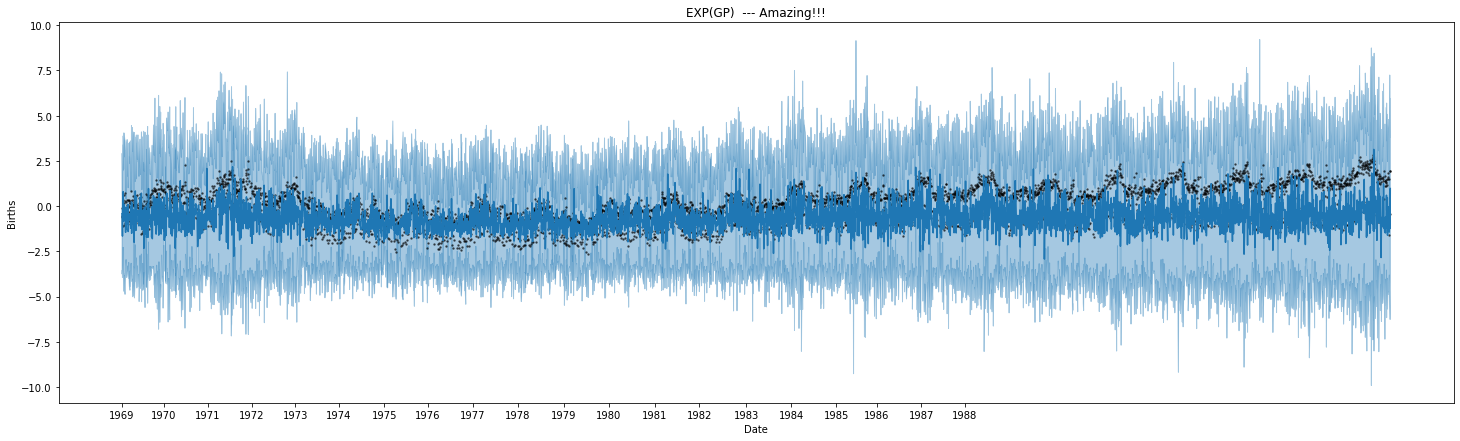

Epoch 100 - Loss:  10431.2046


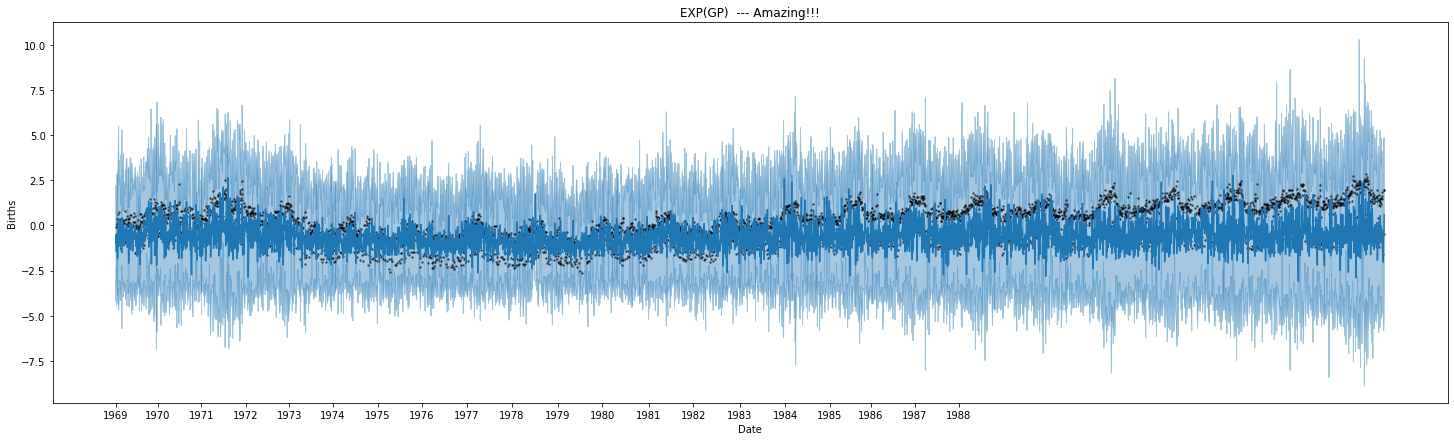

MODEL SUMMARY AFTER OPTIMISATION:


2022-07-21 18:23:45.727431: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: required broadcastable shapes [Op:Mul]

In [10]:
def myModel(M=3000, epochs=100, log_freq=20):

    ### Data
    df_train = pd.read_csv('../data/train.csv')
    df_test = pd.read_csv('../data/test.csv')

    x_train, y_train, m_train = separate_data_with_monday_flag(df_train, normalised=True)
    x_test, y_test, m_test = separate_data_with_monday_flag(df_test, normalised=True)
    x_train = x_train.numpy(); y_train = y_train.numpy(); m_train = m_train.numpy()
    x_test = x_test.numpy(); y_test = y_test.numpy(); m_test = m_test.numpy()

    def get_xticks(data):
        idss = []; yrs = []
        yr = 1969
        for i in range(20):
            df = data.loc[data.year == yr+i]
            yrs.append(yr+i)
            idss.append(df.index[0])
        return idss, yrs
    pos, labels = get_xticks(df_train)
    pos_test, labels_test = get_xticks(df_test)


    ### Model Specification
    likelihood = CustomTFPConditional(
        distribution_class = tfp.distributions.Normal, 
        loc_transform = tfp.bijectors.Exp(), 
        monday_flag = m_train,
    )

    kernel = gpflow.kernels.SeparateIndependent(
        [
            gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25),
            gpflow.kernels.RBF(),  
        ]
    )

    Z = np.linspace(x.min(), x.max(), M)[:, None]  # [M, 1]
    inducing_variable = gpflow.inducing_variables.SeparateIndependentInducingVariables(
        [
            gpflow.inducing_variables.InducingPoints(Z),  
            gpflow.inducing_variables.InducingPoints(Z),  
        ]
    )

    model = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=inducing_variable,
        num_latent_gps=likelihood.latent_dim,
    )

    ### Fitting Set Up
    train_df = (x_train, y_train); test_df = (x_test, y_test)
    loss_fn = model.training_loss_closure(train_df) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)
    set_trainable(model.kernel.kernels[0].kernels[1].period, False)
    #gpflow.utilities.set_trainable(model.likelihood.variance, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    ### Training Loop
    for epoch in range(1, epochs + 1):
        optimisation_step()

        # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
        if epoch % log_freq == 0 and epoch > 0:
            print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
            Ymean, Yvar = model.predict_y(x_train)
            Ymean = Ymean.numpy().squeeze()
            Ystd = tf.sqrt(Yvar).numpy().squeeze()
            plot_distribution(x_train, y_train, Ymean, Ystd, pos, labels, CI=True)
    
    print('MODEL SUMMARY AFTER OPTIMISATION:')
    print(model)

    Ymean_pred, Yvar_pred = model.predict_y(x_test)
    Ymean_pred = Ymean_pred.numpy().squeeze()
    Ystd_pred = tf.sqrt(Yvar_pred).numpy().squeeze()
    plot_distribution(x_test, y_test, Ymean_pred, Ystd_pred, pos_test, labels_test, CI=True)


myModel()